#### Reproduce key figures from Alarcon, et al. 2019

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import pyccl as ccl

import sys
sys.path.append('../python')

import som

from astropy.table import Table, vstack
from matplotlib.colors import LogNorm
from astropy.cosmology import Planck15 as LCDM

In [3]:
rng = np.random.RandomState(seed=44)

If loading data, run the next cell and the skip to ...

In [4]:
targets = Table.read('../data/feature_likelihood/targets.fits', format='fits')
tracers = Table.read('../data/feature_likelihood/tracers.fits', format='fits')

##### Read in the data

In [62]:
pz_path = '/global/cscratch1/sd/belaa/lsst/repos/pz_bayes/data/feature_likelihood/'

In [63]:
gc_table = Table.read(os.path.join(pz_path, 'dc2_image_photoz_magerr_10y_cuts.fits'), format='fits')

del_dec = (np.max(gc_table['dec_true']) - np.min(gc_table['dec_true']))
del_ra = (np.max(gc_table['ra_true']) - np.min(gc_table['ra_true']))
corr_ra = np.cos(np.mean(np.abs(gc_table['dec_true'])) * np.pi / 180)

In [6]:
print('There are {} objects in this catalog over {} sq degrees.'.format(len(gc_table), int(del_dec * del_ra * corr_ra)));

There are 47188507 objects in this catalog over 326 sq degrees.


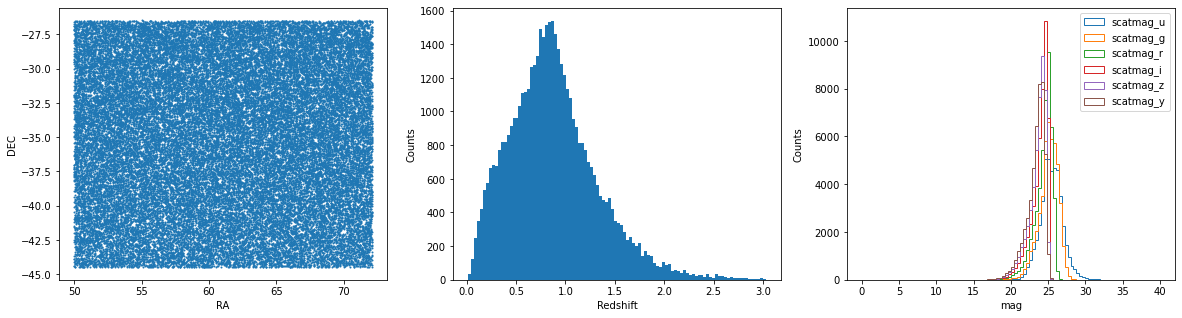

In [10]:
fig, axs = plt.subplots(1,3, figsize=(20,5))
axs = axs.ravel()

axs[0].scatter(gc_table['ra_true'][::1000], gc_table['dec_true'][::1000], s=1)
axs[0].set_xlabel('RA')
axs[0].set_ylabel('DEC')

axs[1].hist(gc_table['redshift_true'][::1000], bins=100)
axs[1].set_xlabel('Redshift')
axs[1].set_ylabel('Counts')

rrange = (0,40)
axs[2].hist(gc_table['scatmag_u'][::1000], bins=100, range=rrange, histtype='step', label='scatmag_u')
axs[2].hist(gc_table['scatmag_g'][::1000], bins=100, range=rrange, histtype='step', label='scatmag_g')
axs[2].hist(gc_table['scatmag_r'][::1000], bins=100, range=rrange, histtype='step', label='scatmag_r')
axs[2].hist(gc_table['scatmag_i'][::1000], bins=100, range=rrange, histtype='step', label='scatmag_i')
axs[2].hist(gc_table['scatmag_z'][::1000], bins=100, range=rrange, histtype='step', label='scatmag_z')
axs[2].hist(gc_table['scatmag_y'][::1000], bins=100, range=rrange, histtype='step', label='scatmag_y')
axs[2].legend(loc='best');
axs[2].set_xlabel('mag')
axs[2].set_ylabel('Counts');

#### Section 3: Simulations
##### Prepare the data

Trim sample to be between `0.2 < z < 1.2`:

In [6]:
z_beg = 0.2
z_end = 1.2

mask_z = np.logical_and(gc_table['redshift_true'] > z_beg, gc_table['redshift_true'] < z_end)
data = gc_table[mask_z]

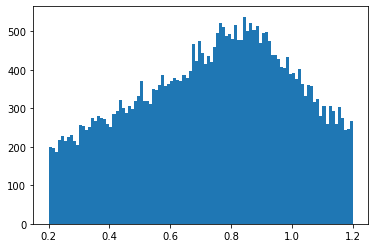

In [7]:
plt.hist(data['redshift_true'][::1000], bins=100);

Make sure we've gotten rid of outlier magnitudes (huge 10-yr depth errors get assigned mag=99):

In [7]:
for band in ['u', 'g', 'r', 'i', 'z', 'y']:
    print(np.max(data['scatmag_'+band]), np.max(data['mag_true_'+band]))

99.0 30.67118
99.0 28.193312
27.174185 26.926336
24.999998 25.275396
25.914871 25.789764
26.816427 25.888395


In [7]:
mask_mag = np.logical_and(data['scatmag_u'] < 99.0, data['scatmag_g'] < 99.0)
data = data[mask_mag]

In [9]:
for band in ['u', 'g', 'r', 'i', 'z', 'y']:
    print(np.max(data['scatmag_'+band]))

34.999645
34.790775
26.928549
24.999998
25.911364
26.816427


In [8]:
len(data)

32985872

Let's look at the redshift histogram once again:

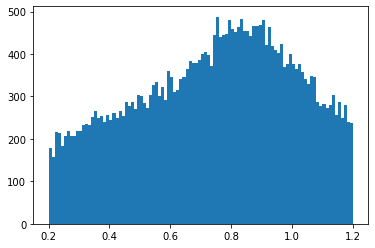

In [12]:
plt.hist(data['redshift_true'][::1000], bins=100);

Apply redshift binning consistent with 20 bins equally spaced in comoving distance:

In [4]:
def get_redshift_bins(zmin=0.2, zmax=1.2, nbins=20, model=LCDM, plot=False):
    z = np.linspace(zmin, zmax, 5 * nbins + 1)
    d = model.comoving_distance(z).value
    d_grid = np.linspace(d[0], d[-1], nbins + 1)
    z_grid = np.interp(d_grid, d, z)
    if plot:
        plt.plot(z, d, '.')
        plt.plot(z_grid, d_grid, 'ro')
        for d in d_grid:
            plt.axhline(d, ls=':')
        for z in z_grid:
            plt.axvline(z, ls=':')
    zc = 0.5 * (z_grid[1:] + z_grid[:-1])
    dV = model.differential_comoving_volume(zc).value
    return z_grid, zc, dV

In [5]:
zbins, zc, dV = get_redshift_bins()

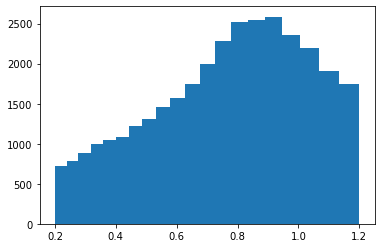

In [12]:
counts, _ , _ = plt.hist(data['redshift_true'][::1000], bins=zbins)

- Generate tracer sample by randomly sampling to maintain constant comoving density per bin. 
- Find the number of galaxies to sample per bin by calculating and then dividing by the comoving volume at the center of each bin.

Is there a difference between the comoving volume at bin center and the average of the differential comoving volume integrated over the width of the bin?

In [35]:
V = LCDM.comoving_volume(zc).value

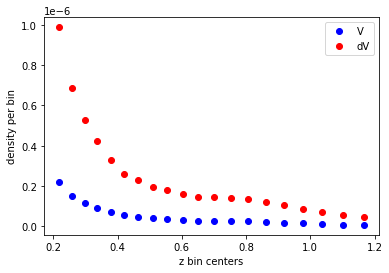

In [50]:
plt.plot(zc, counts / V, 'bo', label='V')
plt.plot(zc, counts / (dV * zc), 'ro', label='dV')
plt.xlabel('z bin centers')
plt.ylabel('density per bin')
plt.legend();

In [12]:
density = 3e-6
V = (dV * zc)

In [13]:
n_per_bin = density * V

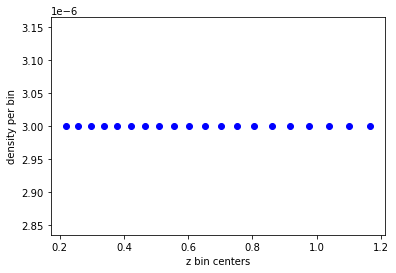

In [15]:
plt.plot(zc, n_per_bin / V, 'bo')
plt.xlabel('z bin centers')
plt.ylabel('density per bin');

In [18]:
tracers = Table(names=data.colnames)
n_per_bin = n_per_bin.astype(int)

for i in range(len(zc)):
    in_bin = np.logical_and(data['redshift_true'] > zbins[i], data['redshift_true'] <= zbins[i+1])
    in_bin_idx = np.argwhere(in_bin == True)[:,0]
    # randomly select tracer galaxies in each bin
    rndm = rng.choice(in_bin_idx, size=n_per_bin[i], replace=False)
    tracers = vstack([tracers, data[rndm]])
    data.remove_rows(rndm)
    
data.write('../data/feature_likelihood/targets.fits', format='fits')
tracers.write('../data/feature_likelihood/tracers.fits', format='fits')

#### Figure 1 (top panel)

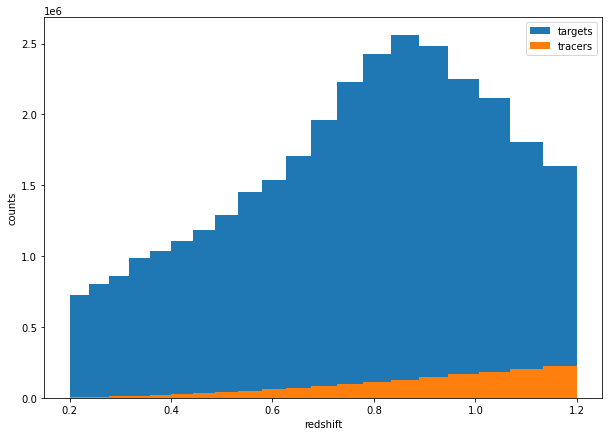

In [24]:
plt.figure(figsize=(10,7))
plt.hist(targets['redshift_true'], bins=zbins, label='targets')
plt.hist(tracers['redshift_true'], bins=zbins, weights=np.full(len(tracers), 2), label='tracers')
plt.xlabel('redshift')
plt.ylabel('counts')
plt.legend();

#### Generate Wide and Deep SOMs

Randomly select 1M galaxies to use for training wide and deep SOM.

In [5]:
size = int(1e6)
rand = rng.choice(len(targets), size=size, replace=False)
train = targets[rand]

In [6]:
def normalize_features(data, colors=True, base=None):
    
    # In case len(data) == 1
    if base is not None:
        norm = (data - np.min(base)) / (np.max(base) - np.min(base))
    
    else:
        norm = (data - np.min(data)) / (np.max(data) - np.min(data))
    
    # Normalize colors between [0,1]  
    if colors:
        return(norm)
    
    # Normalize magnitudes between [0,0.1]
    else:
        return(norm / 10)
    
def prepare_data(data, cols=None):
    
    if cols is None:
        cols = ['mag_true_u', 'mag_true_g', 'mag_true_r', 'mag_true_i', 'mag_true_z', 'mag_true_y']
        
    imag = normalize_features(data[cols[3]], colors=False)
    ui = normalize_features(data[cols[0]] - imag)
    gi = normalize_features(data[cols[1]] - imag)
    ri = normalize_features(data[cols[2]] - imag)
    zi = normalize_features(data[cols[4]] - imag)
    yi = normalize_features(data[cols[5]] - imag)
    
    return(imag, ui, gi, ri, zi, yi)

Build Deep SOM using same features as Wide SOM for single SOM case (where Deep data will be from an LSST deep field):

In [7]:
# Generate features for Deep SOM
imag_deep, ui_deep, gi_deep, ri_deep, zi_deep, yi_deep = prepare_data(train)
#X_deep = np.array([imag_deep, ui_deep, gi_deep, ri_deep, zi_deep, yi_deep]).T
X_deep = np.array([gi_deep, ri_deep, zi_deep]).T
Y_deep = np.asarray(train['redshift_true'])

In [8]:
# SOM arguments
nside = -32
niter = 10

In [ ]:
# Run the SOM
start = time.time()
som_deep = som.SelfOrganizingMap(som.Grid(nside, nside))
som_deep.fit(X_deep, Y_deep, maxiter=niter)
print(time.time() - start)

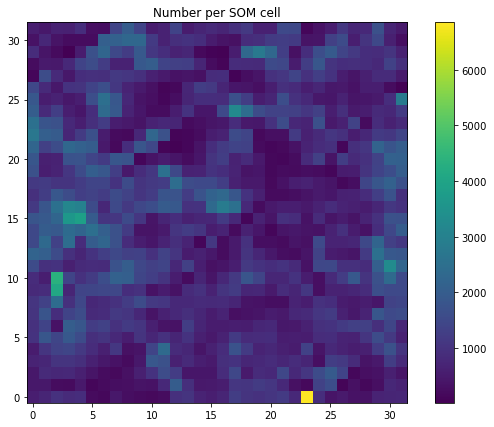

In [21]:
som_deep.plot_counts_per_cell()

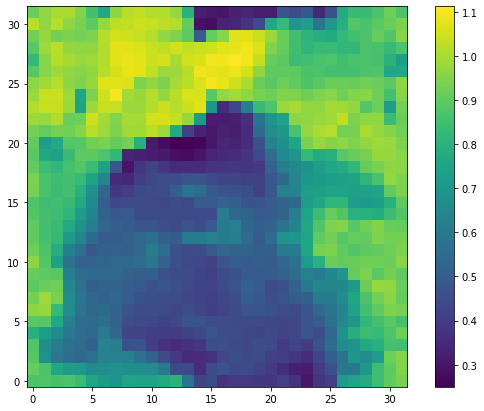

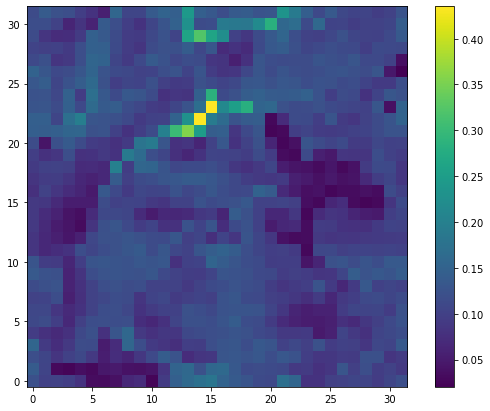

In [15]:
# Mean and sigma per cell
zmean_deep = som_deep.plot_statistic(statistic=np.nanmean, return_stat=True)
zstd_deep = som_deep.plot_statistic(statistic=np.nanstd, return_stat=True)

Use same features for Wide SOM, but using scattered mags instead of true mags:

In [22]:
# Generate features for Wide data 
cols = ['scatmag_u', 'scatmag_g', 'scatmag_r', 'scatmag_i', 'scatmag_z', 'scatmag_y']
imag_wide, ui_wide, gi_wide, ri_wide, zi_wide, yi_wide = prepare_data(train, cols=cols)
#X_wide = np.array([imag_wide, ui_wide, gi_wide, ri_wide, zi_wide, yi_wide]).T
X_wide = np.array([gi_wide, ri_wide, zi_wide]).T
Y_wide = np.asarray(train['redshift_true'])

##### What is below is for a wide sample that uses only imag, gi, ri, zi features.

In [23]:
# Wide SOM arguments
nside_wide = -26
niter_wide = 10

In [ ]:
start = time.time()
som_wide = som.SelfOrganizingMap(som.Grid(nside_wide, nside_wide))
som_wide.fit(X_wide, Y_wide, maxiter=niter_wide)
print(time.time() - start)

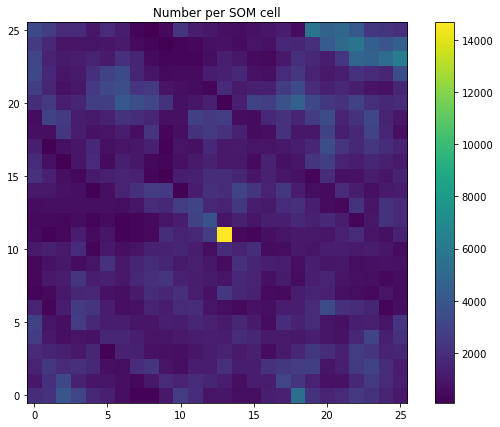

In [25]:
som_wide.plot_counts_per_cell()

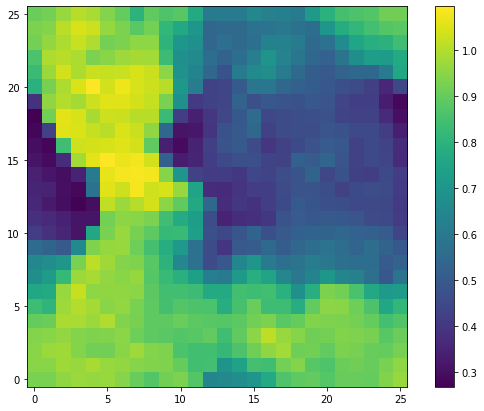

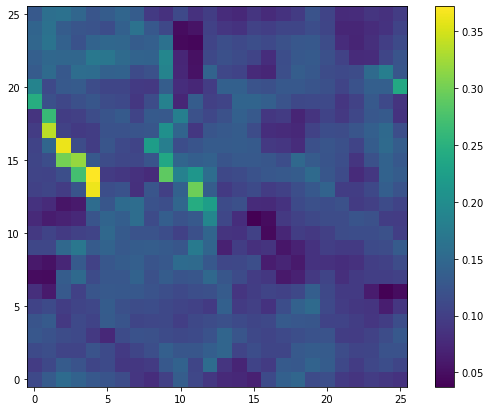

In [26]:
zmean_wide = som_wide.plot_statistic(statistic=np.nanmean, return_stat=True)
zstd_wide = som_wide.plot_statistic(statistic=np.nanstd, return_stat=True)

Note: this is training the Deep SOM with the added `imag` feature.

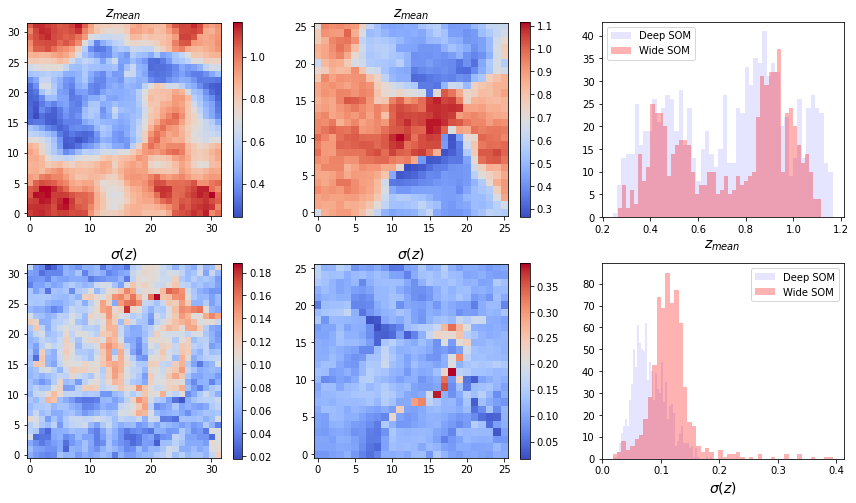

In [47]:
fig, axs = plt.subplots(2,3, figsize=(12,7))
axs = axs.ravel()

im0 = axs[0].imshow(zmean_deep.reshape(som_deep._mapgeom.shape), origin='lower', interpolation='none', cmap='coolwarm')
axs[0].set_title(r'$z_{mean}$', fontsize=14)
fig.colorbar(im0, ax=axs[0])
im1 = axs[1].imshow(zmean_wide.reshape(som_wide._mapgeom.shape), origin='lower', interpolation='none', cmap='coolwarm')
axs[1].set_title(r'$z_{mean}$', fontsize=14)
fig.colorbar(im1, ax=axs[1])
axs[2].hist(zmean_deep, bins=50, alpha=0.1, color='b', label='Deep SOM')
axs[2].hist(zmean_wide, bins=50, alpha=0.3, color='r', label='Wide SOM')
axs[2].set_xlabel(r'$z_{mean}$', fontsize=14)
axs[2].legend()
im3 = axs[3].imshow(zstd_deep.reshape(som_deep._mapgeom.shape), origin='lower', interpolation='none', cmap='coolwarm')
axs[3].set_title(r'$\sigma(z)$', fontsize=14)
fig.colorbar(im3, ax=axs[3])
im4 = axs[4].imshow(zstd_wide.reshape(som_wide._mapgeom.shape), origin='lower', interpolation='none', cmap='coolwarm')
axs[4].set_title(r'$\sigma(z)$', fontsize=14)
fig.colorbar(im4, ax=axs[4])
axs[5].hist(zstd_deep, bins=50, alpha=0.1, color='b', label='Deep SOM')
axs[5].hist(zstd_wide, bins=50, alpha=0.3, color='r', label='Wide SOM')
axs[5].set_xlabel(r'$\sigma(z)$', fontsize=14)
axs[5].legend()
plt.tight_layout()
plt.show()

This is an older version without `imag` feature in Deep SOM (consistent with setup in paper):

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v1/envs/desc/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v1/envs/desc/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


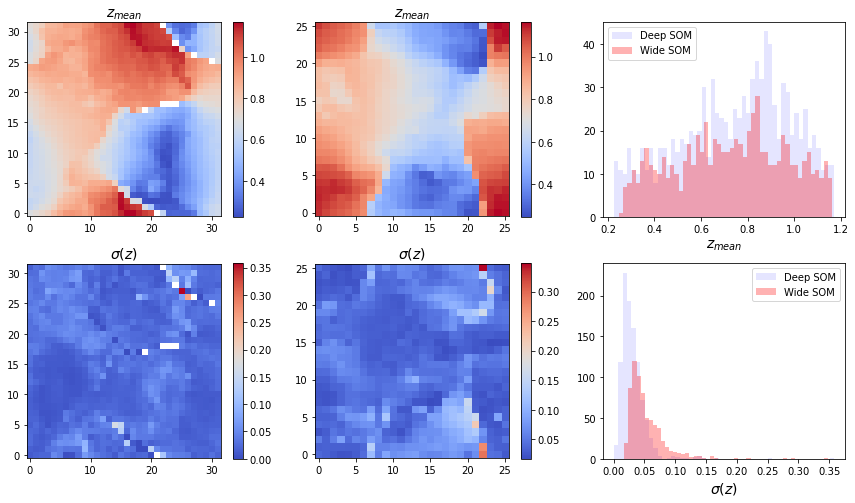

In [21]:
fig, axs = plt.subplots(2,3, figsize=(12,7))
axs = axs.ravel()

im0 = axs[0].imshow(zmean_deep.reshape(som_deep._mapgeom.shape), origin='lower', interpolation='none', cmap='coolwarm')
axs[0].set_title(r'$z_{mean}$', fontsize=14)
fig.colorbar(im0, ax=axs[0])
im1 = axs[1].imshow(zmean_wide.reshape(som_wide._mapgeom.shape), origin='lower', interpolation='none', cmap='coolwarm')
axs[1].set_title(r'$z_{mean}$', fontsize=14)
fig.colorbar(im1, ax=axs[1])
axs[2].hist(zmean_deep, bins=50, alpha=0.1, color='b', label='Deep SOM')
axs[2].hist(zmean_wide, bins=50, alpha=0.3, color='r', label='Wide SOM')
axs[2].set_xlabel(r'$z_{mean}$', fontsize=14)
axs[2].legend()
im3 = axs[3].imshow(zstd_deep.reshape(som_deep._mapgeom.shape), origin='lower', interpolation='none', cmap='coolwarm')
axs[3].set_title(r'$\sigma(z)$', fontsize=14)
fig.colorbar(im3, ax=axs[3])
im4 = axs[4].imshow(zstd_wide.reshape(som_wide._mapgeom.shape), origin='lower', interpolation='none', cmap='coolwarm')
axs[4].set_title(r'$\sigma(z)$', fontsize=14)
fig.colorbar(im4, ax=axs[4])
axs[5].hist(zstd_deep, bins=50, alpha=0.1, color='b', label='Deep SOM')
axs[5].hist(zstd_wide, bins=50, alpha=0.3, color='r', label='Wide SOM')
axs[5].set_xlabel(r'$\sigma(z)$', fontsize=14)
axs[5].legend()
plt.tight_layout()
plt.show()

In [23]:
def mkbins(zmean, ngals, nbins=5):
    ncells = len(zmean)
    # sort cells by zmean.
    idx = np.argsort(zmean)
    # split into contiguous bins with equal number of galaxies.
    fracgals = np.cumsum(ngals[idx]) / ngals.sum()
    breaks = np.arange(1, nbins + 1) / nbins
    splits = np.round(np.interp(breaks, fracgals, np.arange(ncells))).astype(int)
    splits[-1] = ncells
    ibin = np.empty(ncells)
    hi = 0
    for k in range(nbins):
        lo = hi
        hi = splits[k]
        ibin[idx[lo:hi]] = k
    #plt.plot(ibin[idx], '.')
    return(ibin)

def plotbins(ztrue, ibin, zbinning):
    nbins = int(ibin.max() + 1)
    plt.figure(figsize=(10,7))
    for k in range(nbins):
        sel = np.concatenate(ztrue[ibin == k])
        plt.hist(sel, bins=zbinning, histtype='step', lw=2, label=f'Bin {k}')
    plt.xlabel('Redshift', fontsize=14)
    plt.ylabel('Number counts', fontsize=14)
    plt.legend(title='Tomographic bins', loc=2)

In [28]:
ngals_deep = som_deep._counts.reshape(som_deep._mapgeom.size)
ibin_deep = mkbins(zmean_deep, ngals_deep)

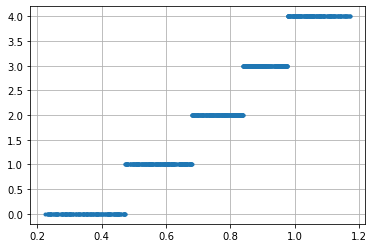

In [29]:
plt.plot(zmean_deep, ibin_deep, '.')
plt.grid();

#### Figure 1 (bottom panel)

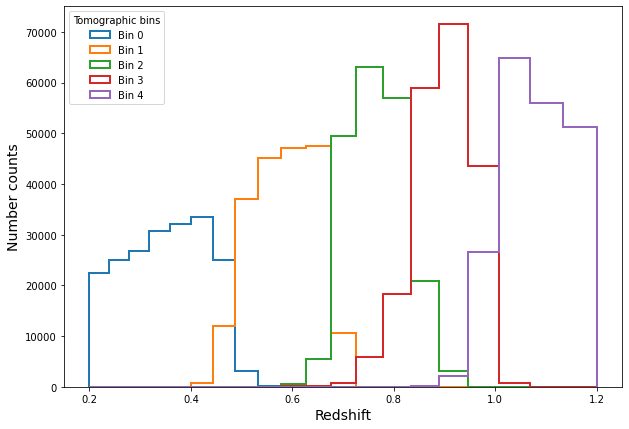

In [30]:
plotbins(np.array(som_deep._target_dist), ibin_deep, zbins)

In [31]:
ngals_wide = som_wide._counts.reshape(som_wide._mapgeom.size)
ibin_wide = mkbins(zmean_wide, ngals_wide)

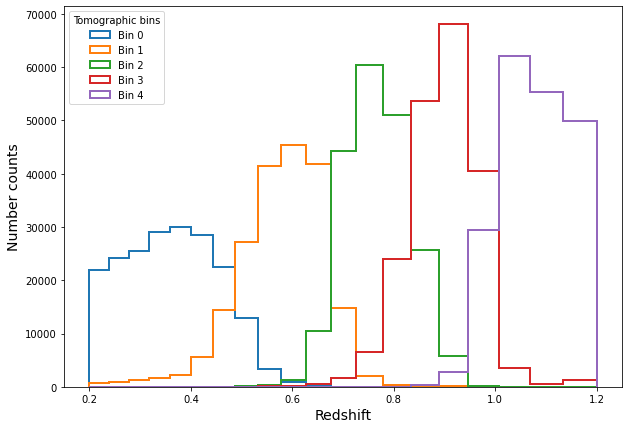

In [32]:
plotbins(np.array(som_wide._target_dist), ibin_wide, zbins)

#### Use 1 SOM and Gaussian 'cloud' of points

In [35]:
def mag_to_flux(mag, magerr):
        
    # convert AB mag to flux
    f0 = 3631 # Jy
    exp = -mag / 2.5
    flux = f0 * 10 ** exp
    fluxerr = 0.4 * np.log(10) * flux * magerr
    return(flux, fluxerr)

def flux_to_mag(flux, luptimag=True):
    
    if luptimag:
        # from Eq. 19 in pheno-z paper
        a = np.log10(np.e)
        b = 1.024 * np.std(flux)
        f0 = 3631 # Jy
        mu0 = f0 - 2.5 * np.log10(b)
        mu = mu0 - a * np.arcsinh(flux / (2 * b))
        return(mu)

    else:
        f0 = 3631 # Jy
        mag = -2.5 * np.ma.log10(flux / f0)
        return(mag)

def flux_fluxerr(table):
    
    flux_u, fluxerr_u = mag_to_flux(table['scatmag_u'], table['scaterr_u'])
    flux_g, fluxerr_g = mag_to_flux(table['scatmag_g'], table['scaterr_g'])
    flux_r, fluxerr_r = mag_to_flux(table['scatmag_r'], table['scaterr_r'])
    flux_i, fluxerr_i = mag_to_flux(table['scatmag_i'], table['scaterr_i'])
    flux_z, fluxerr_z = mag_to_flux(table['scatmag_z'], table['scaterr_z'])
    flux_y, fluxerr_y = mag_to_flux(table['scatmag_y'], table['scaterr_y'])
    
    return(flux_u, fluxerr_u, flux_g, fluxerr_g, flux_r, fluxerr_r, flux_i, fluxerr_i, flux_z, fluxerr_z, flux_y, fluxerr_y)

def sample_cloud(table):
    
    size = len(table)
    cloud = np.empty((size, 6))
    
    flux_u, fluxerr_u, flux_g, fluxerr_g, flux_r, fluxerr_r, flux_i, fluxerr_i, flux_z, fluxerr_z, flux_y, fluxerr_y = flux_fluxerr(table)
    
    for k in range(size):
        mean = [flux_u[k], flux_g[k], flux_r[k], flux_i[k], flux_z[k], flux_y[k]]
        cov = [fluxerr_u[k] ** 2, fluxerr_g[k] ** 2, fluxerr_r[k] ** 2, fluxerr_i[k] ** 2, fluxerr_z[k] ** 2, fluxerr_y[k] ** 2]
        cloud[k] = rng.multivariate_normal(mean, np.diag(cov))
        
    return(cloud)

In [28]:
cloud = sample_cloud(train)

In [29]:
cloud.shape

(1000000, 6)

In [36]:
cloud_mags = flux_to_mag(cloud)

In [37]:
cloud_mags[:,0]

array([3643.18571461, 3643.19029138, 3643.19305606, ..., 3643.19200671,
       3643.18694072, 3643.19075037])

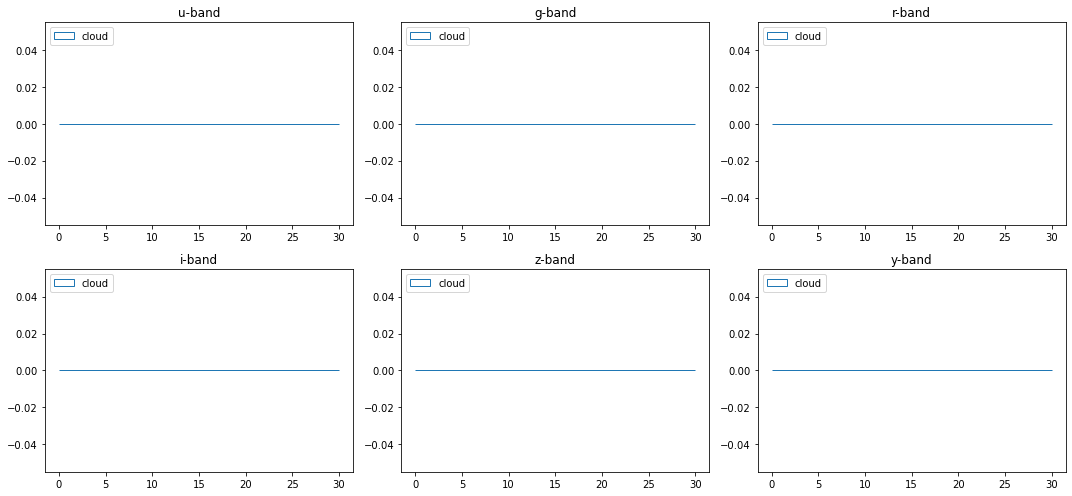

In [33]:
fig, axs = plt.subplots(2,3, figsize=(15,7))
axs = axs.ravel()

cc = ['u', 'g', 'r', 'i', 'z', 'y']

bb = np.linspace(0,30,50)

for i, band in enumerate(cc):
    axs[i].hist(cloud_mags[:,i], bins=bb, histtype='step', label='cloud')
    #axs[i].hist(train['scatmag_{}'.format(band)], bins=bb, histtype='step', label='wide')
    axs[i].legend(loc=2)
    axs[i].set_title('{}-band'.format(band))
plt.tight_layout();

In [33]:
# Some u- and g-band fluxes are negative 
for i in range(6):
    print(np.min(cloud[:,i]), np.max(cloud[:,i]))

-2.2586949437385865e-07 7.21010787735938e-05
-1.532515218794958e-08 0.00022499859368223466
7.636595472341081e-08 0.0006475253314857347
2.999926350591756e-07 0.0010272358716445246
2.128021028794999e-07 0.001384510060887533
5.068178503113025e-08 0.0016899930784644523


In [16]:
# Mask negative fluxes
mask = cloud <= 0
masked_cloud = np.ma.masked_array(cloud, mask=mask.astype(int))

# Convert back to mags
mag_cloud = flux_to_mag(masked_cloud)

In [17]:
# Put cloud sample in a table
cloud_cols = ('mag_u', 'mag_g', 'mag_r', 'mag_i', 'mag_z', 'mag_y')
cloud_table = Table(mag_cloud, names=(cloud_cols))

In [23]:
# Normalize features in order to find each galaxy's best matching cell in the Deep SOM
imag_cloud, ui_cloud, gi_cloud, ri_cloud, zi_cloud, yi_cloud = prepare_data(cloud_table, cols=cloud_cols)
#X_cloud = np.array([imag_cloud, ui_cloud, gi_cloud, ri_cloud, zi_cloud, yi_cloud]).T
X_cloud = np.array([gi_cloud, ri_cloud, zi_cloud]).T
Y_cloud = np.asarray(train['redshift_true'])

#### Compare cloud data with the wide data it was sampled from:

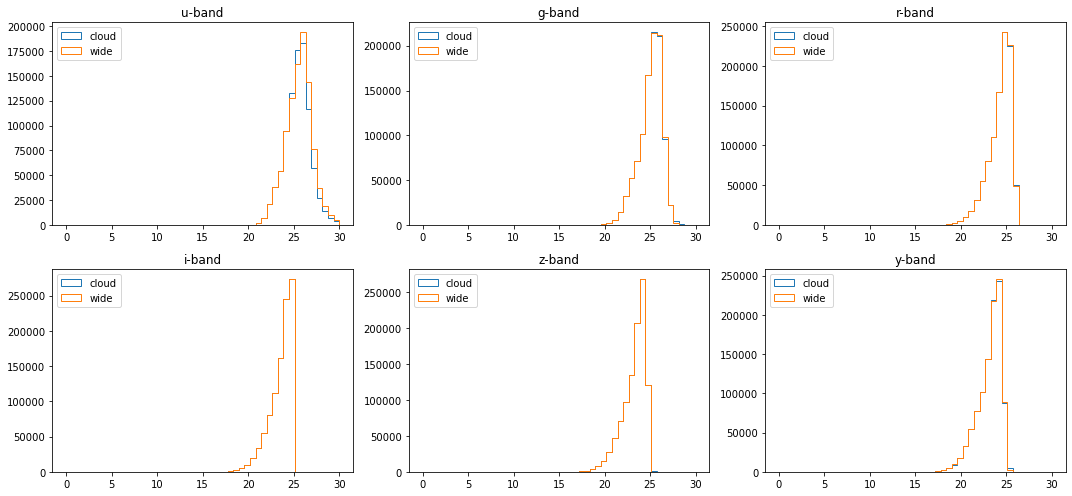

In [22]:
fig, axs = plt.subplots(2,3, figsize=(15,7))
axs = axs.ravel()

cc = ['u', 'g', 'r', 'i', 'z', 'y']

bb = np.linspace(0,30,50)

for i, band in enumerate(cc):
    axs[i].hist(mag_cloud[:,i], bins=bb, histtype='step', label='cloud')
    axs[i].hist(train['scatmag_{}'.format(band)], bins=bb, histtype='step', label='wide')
    axs[i].legend(loc=2)
    axs[i].set_title('{}-band'.format(band))
plt.tight_layout();

#### Same comparison, but with normalized colors:

What is going on with `g-i` band??

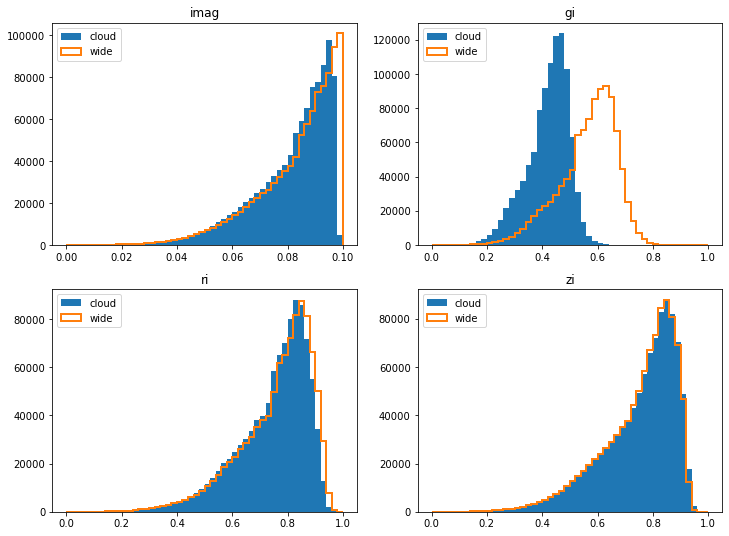

In [21]:
fig, axs = plt.subplots(2,2, figsize=(12,9))
axs = axs.ravel()

axs[0].hist(imag_cloud, bins=50, label='cloud')
axs[0].hist(imag_wide, bins=50, label='wide', histtype='step', lw=2)
axs[0].set_title('imag')
axs[0].legend(loc=2)

axs[1].hist(gi_cloud, bins=50, label='cloud')
axs[1].hist(gi_wide, bins=50, label='wide', histtype='step', lw=2)
axs[1].set_title('gi')
axs[1].legend(loc=2)

axs[2].hist(ri_cloud, bins=50, label='cloud')
axs[2].hist(ri_wide, bins=50, label='wide', histtype='step', lw=2)
axs[2].set_title('ri')
axs[2].legend(loc=2)

axs[3].hist(zi_cloud, bins=50, label='cloud')
axs[3].hist(zi_wide, bins=50, label='wide', histtype='step', lw=2)
axs[3].set_title('zi')
axs[3].legend(loc=2);

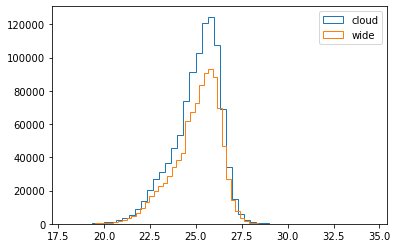

In [24]:
plt.hist(cloud_table['mag_g'], bins=50, histtype='step', label='cloud')
plt.hist(train['scatmag_g'], bins=50, histtype='step', label='wide')
plt.legend();

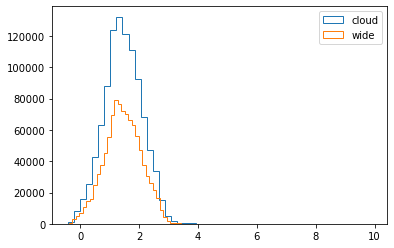

In [25]:
plt.hist(cloud_table['mag_g'] - cloud_table['mag_i'], bins=50, histtype='step', label='cloud')
plt.hist(train['scatmag_g'] - train['scatmag_i'], bins=50, histtype='step', label='wide')
plt.legend();

In [30]:
np.min(cloud_table['mag_g'] - cloud_table['mag_i']), np.min(train['scatmag_g'] - train['scatmag_i'])

(-0.4234872510088543, -0.39167976)

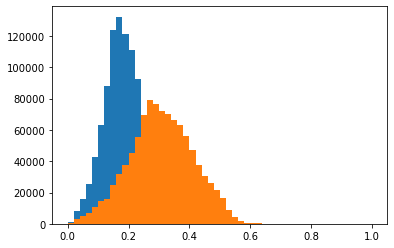

In [29]:
plt.hist(normalize_features(cloud_table['mag_g'] - cloud_table['mag_i']), bins=50)
plt.hist(normalize_features(train['scatmag_g'] - train['scatmag_i']), bins=50);

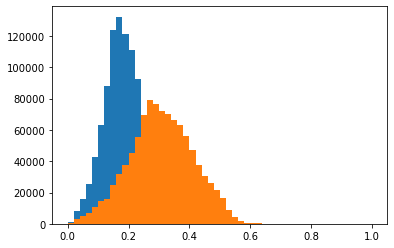

In [35]:
plt.hist(((cloud_table['mag_g'] - cloud_table['mag_i']) - np.min(cloud_table['mag_g'] - cloud_table['mag_i'])) / 
         (np.max(cloud_table['mag_g'] - cloud_table['mag_i']) - np.min(cloud_table['mag_g'] - cloud_table['mag_i'])) , bins=50)
plt.hist(((train['scatmag_g'] - train['scatmag_i']) - np.min(train['scatmag_g'] - train['scatmag_i'])) / 
         (np.max(train['scatmag_g'] - train['scatmag_i']) - np.min(train['scatmag_g'] - train['scatmag_i'])), bins=50);

In [51]:
np.max(cloud_table['mag_g'] - cloud_table['mag_i']) - np.min(cloud_table['mag_g'] - cloud_table['mag_i'])

10.334355715300934

In [52]:
np.max(train['scatmag_g'] - train['scatmag_i']) - np.min(train['scatmag_g'] - train['scatmag_i'])

5.9625072

In [28]:
bmu_wide = som_deep.find_bmu(X_wide)
z_wide = np.array(som_deep._target_vals)[bmu_wide]

In [34]:
bmu_cloud = som_deep.find_bmu(X_cloud)
z_cloud = np.array(som_deep._target_vals)[bmu_cloud]

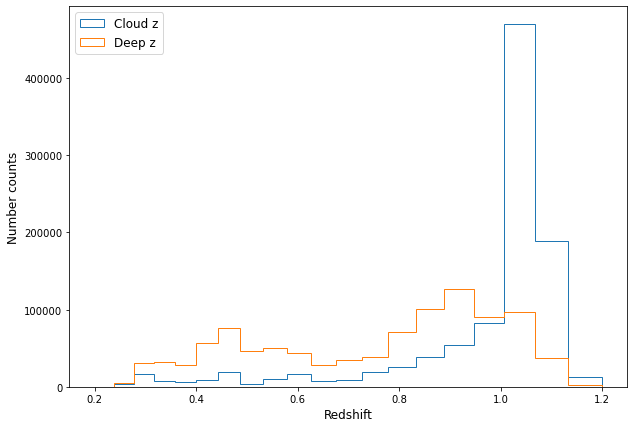

In [31]:
plt.figure(figsize=(10,7))
plt.hist(z_wide, bins=zbins, histtype='step', label='Cloud z')
plt.hist(som_deep._target_pred, bins=zbins, histtype='step', label='Deep z')
plt.xlabel('Redshift', fontsize=12)
plt.ylabel('Number counts', fontsize=12)
plt.legend(fontsize=12, loc=2);

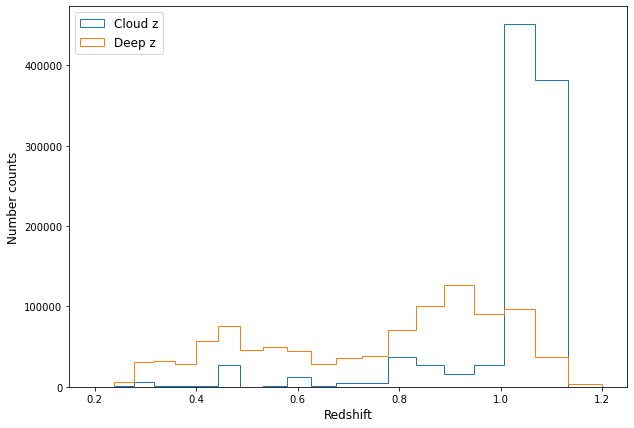

In [35]:
plt.figure(figsize=(10,7))
plt.hist(z_cloud, bins=zbins, histtype='step', label='Cloud z')
plt.hist(som_deep._target_pred, bins=zbins, histtype='step', label='Deep z')
plt.xlabel('Redshift', fontsize=12)
plt.ylabel('Number counts', fontsize=12)
plt.legend(fontsize=12, loc=2);

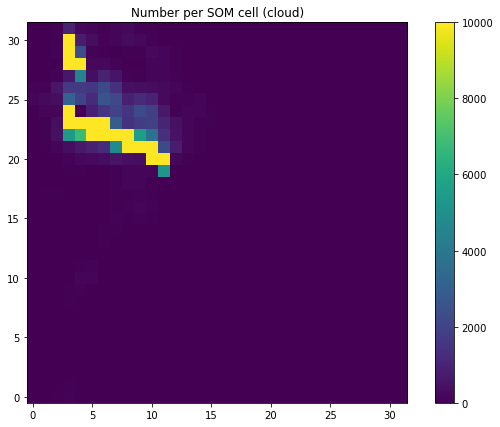

In [38]:
counts_cloud = np.bincount(bmu_cloud, minlength=(som_deep._mapgeom.size)).reshape(som_deep._mapgeom.shape)

plt.figure(figsize=(10,7))
plt.imshow(counts_cloud, origin='lower', interpolation='none', cmap='viridis', vmin=0, vmax=10000)
plt.colorbar()
plt.title('Number per SOM cell (cloud)')
plt.show()

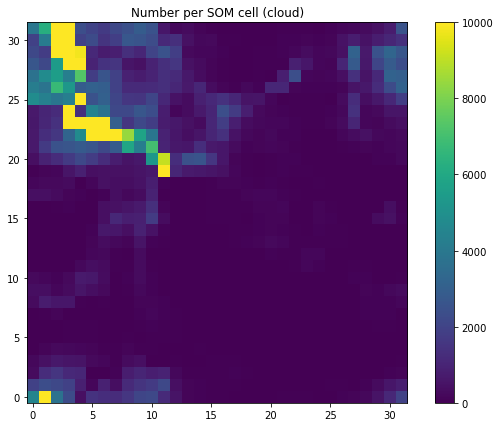

In [39]:
counts_wide = np.bincount(bmu_wide, minlength=(som_deep._mapgeom.size)).reshape(som_deep._mapgeom.shape)

plt.figure(figsize=(10,7))
plt.imshow(counts_wide, origin='lower', interpolation='none', cmap='viridis', vmin=0, vmax=10000)
plt.colorbar()
plt.title('Number per SOM cell (cloud)')
plt.show()

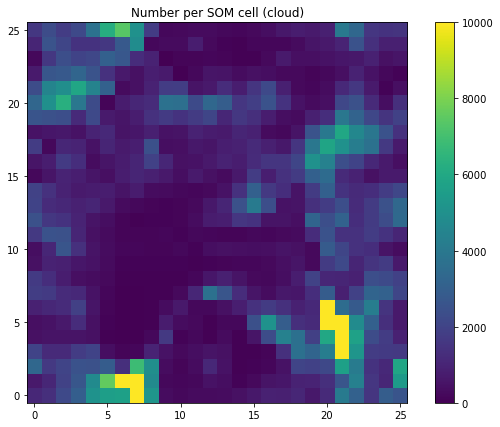

In [60]:
counts_cloud = np.bincount(bmu_cloud, minlength=(som_wide._mapgeom.size)).reshape(som_wide._mapgeom.shape)

plt.figure(figsize=(10,7))
plt.imshow(counts_cloud, origin='lower', interpolation='none', cmap='viridis', vmin=0, vmax=10000)
plt.colorbar()
plt.title('Number per SOM cell (cloud)')
plt.show()

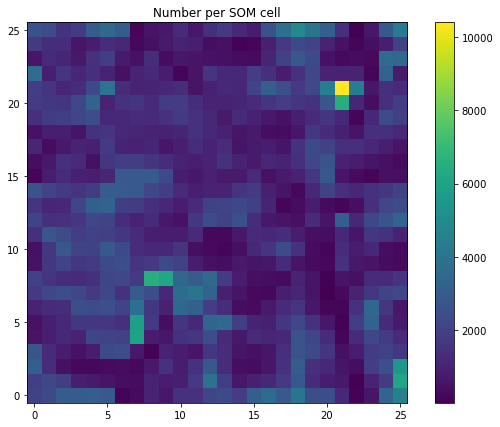

In [55]:
som_wide.plot_counts_per_cell()

#### Plot SED in cell

In [56]:
def plot_sed(tsom, table, cell):
        
        colnames = []
        for col in table.colnames:
            if 'sed' in col:
                colnames.append(col)
                    
        in_cell = table[tsom._indices == cell]
        if len(in_cell) == 0:
            return('No galaxies were mapped to this cell.')
        rnd = rng.choice(len(in_cell), size=1)
        sed = in_cell[rnd]

        plt.figure(figsize(10,7))
        wlen = np.empty(len(colnames))
        mags = np.empty(len(colnames))
        for k, sed_col in enumerate(colnames):
            to_jy = 1 / (4.4659e13 / (8.4 ** 2))
            jy = sed[sed_col] * to_jy
            ab = -2.5 * np.log10(jy / 3631)
            start, width = colnames[k].split('_')[1:]
            start, width = int(start), int(width)
            wlen[k] =  (start + (start + width)) / 2 # angstroms
            mags[k] = ab
        x = cell % np.abs(tsom._mapgeom.shape[0])
        y = cell // np.abs(tsom._mapgeom.shape[1])
        t = (f'Cell # {cell}, x = {x}, y = {y} \n'
             f'Photo-z estimate: {np.round(tsom._target_pred[cell], 3)}\n'
             f'# Objects in cell: {len(in_cell)}')
        plt.plot(wlen, mags, 'ro')
        plt.axis([500, 18500, np.min(mags) - 0.5, np.max(mags) + 0.5])
        plt.text(10000, np.mean(mags) + 0.5, t, ha='left', wrap=True)
        plt.gca().invert_yaxis()
        plt.xlabel(r'$\AA$')
        plt.ylabel(r'$m_{AB}$')
        plt.show()

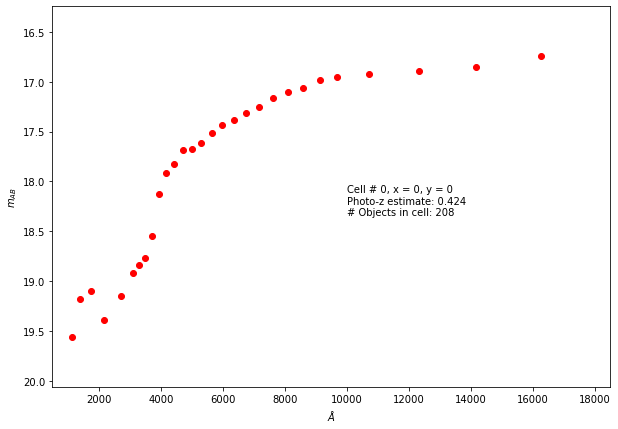

In [57]:
plot_sed(som_deep, train, cell=0)